# Explore time confound method in Alvarado et al., 2021


In [4]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.classifier_utils as classifier_utils

import utils.io_utils as io_utils
import utils.behavioral_utils as behavioral_utils

from matplotlib import pyplot as plt
import matplotlib
import utils.spike_utils as spike_utils
import utils.subspace_utils as subspace_utils
from utils.session_data import SessionData
from constants.behavioral_constants import *
from constants.decoding_constants import *
import seaborn as sns
from scripts.pseudo_decoding.single_selected_feature_configs import *
import scipy
import argparse
import copy

from models.trainer import Trainer
from models.model_wrapper import ModelWrapper, ModelWrapperLinearRegression
from models.multinomial_logistic_regressor import NormedDropoutMultinomialLogisticRegressor
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 
from sklearn.linear_model import LogisticRegression
import itertools

from sklearn.model_selection import cross_val_score


### Load data

In [5]:
subject = "SA"
session = "20180802"

pre_interval = 1800
post_interval = 1500
event = "FeedbackOnset"
interval_size = 100

beh = behavioral_utils.get_valid_belief_beh_for_sub_sess(subject, session)
spikes_path = io_utils.SESS_SPIKES_PATH.format(
    sub=subject,
    sess_name=session, 
    fr_type="firing_rates",
    pre_interval=pre_interval, 
    event=event, 
    post_interval=post_interval, 
    interval_size=interval_size,
)
frs = pd.read_pickle(spikes_path)

### Code from Ilse

In [6]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Lasso

def _remove_trial_components(fr_vals, trials):
    lasso = Lasso(alpha=1e-2).fit(trials, fr_vals)
    a, b = lasso.predict(np.arange(2)[:, None])
    vec = b - a
    if np.allclose(vec, 0):
        print("lasso not predicting anything, we're done")
        return fr_vals
    vec /= np.linalg.norm(vec)
    scores = fr_vals @ vec
    print("starting grid search")
    krr = GridSearchCV(
        KernelRidge(kernel="rbf"),
        dict(alpha=np.geomspace(1e-2, 1e2, 8), gamma=np.geomspace(1e-2, 1e8, 8)),
        cv=5,
    ).fit(trials, scores)
    r_2 = cross_val_score(krr.best_estimator_, trials, scores, cv=KFold(5, shuffle=True)).mean()
    print(f"kernel ridge R^2: {r_2}, params: {krr.best_estimator_}")
    if (r_2 < 0):
        print("kernel no good, original frs")
        return fr_vals
    else:
        vec = vec.reshape(1, -1)
        predictive = krr.predict(trials).reshape(-1, 1) @ vec
        # adding back the mean seems strange, but we do actually want to do this
        # 1. this just means we won't change the incoming data's mean along the `vec` axis
        # 2. Singh Alvarado et al. 2021 does this too
        return fr_vals - predictive + scores.mean().reshape(-1, 1) @ vec
        



def remove_trial_components(fr_vals, trials):
    """
    fr_vals: n_trials x n_units
    trials: n_trials
    """
    while True:
        fig, ax = plt.subplots()
        ax.plot(fr_vals[:, 0])
        residuals = _remove_trial_components(fr_vals, trials)
        print(np.sum(np.abs(fr_vals - residuals)))
        if (abs(fr_vals - residuals) < 1e-10).all():
            break
        fr_vals = residuals
    return residuals

In [7]:
time_bin_frs = frs[np.isclose(frs.TimeBins, 0.0)]

In [8]:
fr_vals = time_bin_frs[["TrialNumber", "UnitID", "FiringRate"]].pivot_table(index="TrialNumber", columns="UnitID").values

starting grid search
kernel ridge R^2: 0.02970414621733868, params: KernelRidge(alpha=1.9306977288832496, gamma=0.01, kernel='rbf')
31428.79531748967
starting grid search
kernel ridge R^2: -0.178983937943504, params: KernelRidge(alpha=1.9306977288832496, gamma=0.01, kernel='rbf')
kernel no good, original frs
0.0


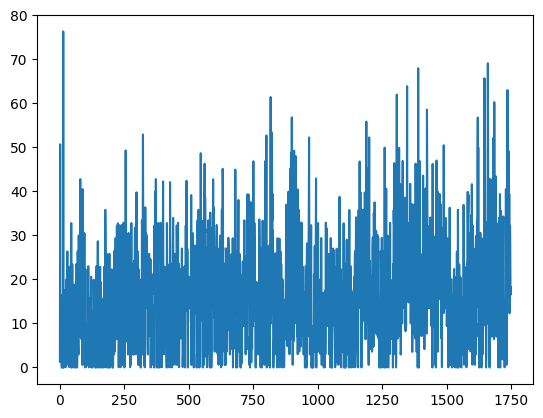

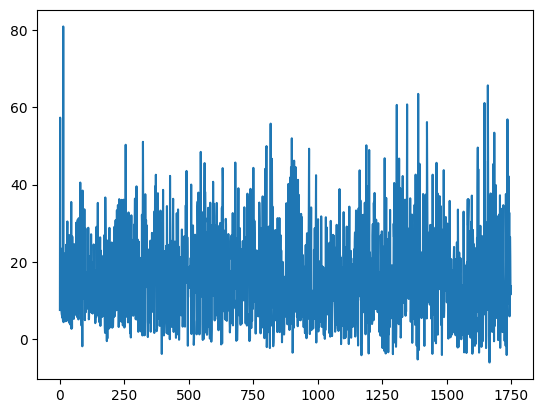

In [9]:
res = remove_trial_components(fr_vals, frs.TrialNumber.unique().reshape(-1, 1))

In [80]:
df = pd.DataFrame(res, columns=frs.UnitID.unique())
df["TrialNumber"] = frs.TrialNumber.unique()

In [84]:
adjusted = df.melt(id_vars=["TrialNumber"], value_vars=np.arange(frs.UnitID.nunique()), var_name="UnitID", value_name="FiringRate")

<Axes: xlabel='TrialNumber', ylabel='FiringRate'>

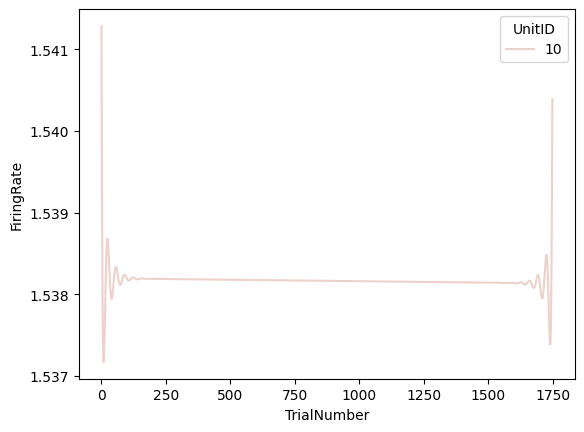

In [91]:
sns.lineplot(adjusted[adjusted.UnitID == 10], x="TrialNumber", y="FiringRate", hue="UnitID")